In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import scipy
from scipy import spatial

In [2]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80

### Hyperparameters initialisation:

In [3]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [4]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [5]:
#number of rbf centers
num_phi_rbf = 100

#sigma of the radial basis function
phi_rbf_sigma =5.0 

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20

In [6]:
#dimension of the latent variable z that embeds beta
z_dim = 25

In [7]:
# Gives the numbers of betas to learn
num_training_funcs = 2000

In [8]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
K = 80

In [9]:
#the encoder and the decoder parts each have 3 layers
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 512
decoder_h_dim_3 = 512

In [10]:
s_lims =[-5.0, 5.0]

In [11]:
#Define the exponential kernel: l is the lengthscale parameter. 
def exponential_kernel(t_i, t_j, l, sigma_f):    
    dist = scipy.spatial.distance.cdist(t_i, t_j, 'euclidean')
    
    return sigma_f**2 * np.exp(-0.5 / l**2 * dist)

In [12]:
lengthscale=1.0
sigma_f=1.0

In [13]:
def generate_OU_dataset_with_kernel(lengthscale, sigma_f):
    
    locations_append=[]
    OU_samples_append=[]
    
    for fct_id in range(num_training_funcs):
        #print("fct_id:")
        #print(fct_id)
        
        locations = np.random.uniform(s_lims[0], s_lims[1],size=(K,1))  
        #compute correlation matrix between those K locations
        cov = exponential_kernel(locations, locations, lengthscale, sigma_f)
        #cov.shape
        
        mu = np.zeros(locations.shape)
        
        OU_sample = np.random.multivariate_normal(mu.ravel(), cov, 1)        
            
        locations_append.append(locations)
        OU_samples_append.append(OU_sample)
        
    
    return np.array(locations_append), np.array(OU_samples_append)
    

In [14]:
dataset_locations, dataset_OU=generate_OU_dataset_with_kernel(lengthscale, sigma_f)

In [15]:
dataset_locations.shape

(2000, 80, 1)

In [16]:
dataset_OU.shape

(2000, 1, 80)

In [17]:
dataset_loc_training=dataset_locations[:1500,:,:]
dataset_OU_training=dataset_OU[:1500,:,:]

In [18]:
dataset_loc_test=dataset_locations[1500:,:,:]
dataset_OU_test=dataset_OU[1500:,:,:]

In [19]:
#dataset_loc_training.shape
dataset_OU_training.shape

(1500, 1, 80)

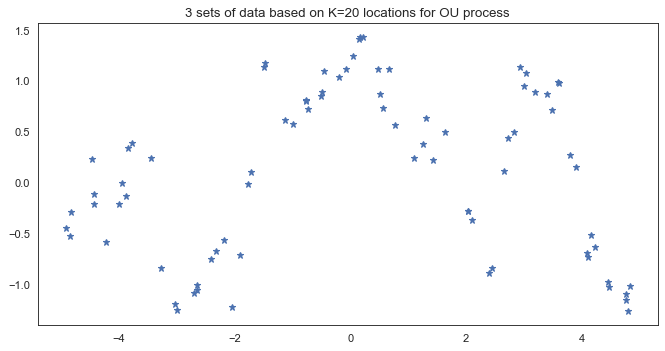

In [78]:
for i in range(1):
    plt.plot(dataset_locations[i,:,0],dataset_OU[i,0,:],"*")
plt.title("3 sets of data based on K=20 locations for OU process")
plt.show()

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
    
        self.phi_rbf_centers = nn.Parameter(torch.tensor(
            np.random.uniform(s_lims[0], s_lims[1],
            size=(num_phi_rbf, input_dim))))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, z_dim * 2)
        #self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        #self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        #self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, beta_dim)
        #self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        #self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        #self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        # self.betas = nn.Parameter(torch.ones(num_training_funcs, beta_dim))
        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-0.1, 0.1, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)


    def Phi(self, input):
        #print('input size')
        #print(input.shape)
        
        input_expand = torch.unsqueeze(input, 1)
        #print('input_expand size')
        #print(input_expand.shape)
        
        #print('self.phi_rbf_centers size')
        #print(self.phi_rbf_centers.shape)
        
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        #print('phi_expand size')
        #print(phi_expand.shape)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)

        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = F.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5
     

    def encoder(self, input):
        
        # input (batch x beta_dim) output ((batch x z_dim), (batch x z_dim))
        M1 = self.encoder_nn_1(input)
        #M2 = F.relu(self.encoder_nn_2(M1))
        #M3 = F.relu(self.encoder_nn_3(M2))
        #M4 = self.encoder_nn_4(M3)
        z_mean = M1[:, 0:z_dim]
        z_std = torch.exp(M1[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        # input (batch x z_dim) output (batch x beta_dim)
        M1 = self.decoder_nn_1(input)
        #M2 = F.relu(self.decoder_nn_2(M1))
        #M3 = F.relu(self.decoder_nn_3(M2))
        #M4 = self.decoder_nn_4(M3)
        return M1
    
    
    

    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
        
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x): 
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))       
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())         
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

    
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)       
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        return loss_term_3       
        

   
    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]

        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)

        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2

     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),
            dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    # Compute decoded OU values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)       
        beta_hat = self.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat
   

    # This function returns decoded values of x when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):               
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()        
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

In [22]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=50, bias=True)
  (decoder_nn_1): Linear(in_features=25, out_features=100, bias=True)
)

In [23]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 1
current_max = 1500
interval = 3

total_nbr_epochs=300

In [24]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [25]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [26]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_loc_training[function_id])
        x_vals = torch.tensor(dataset_OU_training[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+1, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0


/Users/tresniaberah/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L1 0.6761815996721371 L2 0.8514199775650377 L3 0.005714451749742071 Loss 1.5333160289869168 num funcs 2
epoch id: 1
L1 1.1388098193173837 L2 6.531923682821733 L3 0.007333983896677471 Loss 7.678067486035793 num funcs 2
epoch id: 2
L1 1.1322623946893073 L2 2.6652207720318275 L3 0.0075161986180041305 Loss 3.804999365339138 num funcs 2
epoch id: 3
L1 1.129156473512479 L2 2.4324053176306197 L3 0.007588981716366997 Loss 3.569150772859466 num funcs 3
epoch id: 4
L1 0.9581742192076218 L2 3.6123148302574997 L3 0.007157105985023608 Loss 4.577646155450144 num funcs 3
epoch id: 5
L1 0.9544635695670212 L2 3.200637173508221 L3 0.0073425237412245055 Loss 4.162443266816467 num funcs 3
epoch id: 6
L1 0.9520764726772413 L2 4.731464061125084 L3 0.007462164651488524 Loss 5.691002698453815 num funcs 4
epoch id: 7
L1 1.0639337142221423 L2 4.115834666997703 L3 0.007258718392815776 Loss 5.187027099612661 num funcs 4
epoch id: 8
L1 1.0566084452198212 L2 2.8372992157838497 L3 0.007364595563340231 Loss 3.9012722

L1 0.41988236729139705 L2 0.7351942313123416 L3 0.08119119555970596 Loss 1.2362677941634446 num funcs 25
epoch id: 72
L1 0.4130856069923132 L2 0.74813228044044 L3 0.08598466458414465 Loss 1.2472025520168977 num funcs 26
epoch id: 73
L1 0.4153201472444064 L2 0.6804971749235657 L3 0.0883133219068997 Loss 1.1841306440748718 num funcs 26
epoch id: 74
L1 0.41011302644199954 L2 0.666494105869275 L3 0.0928343753041382 Loss 1.1694415076154128 num funcs 26
epoch id: 75
L1 0.40710660749002314 L2 0.6377083670222741 L3 0.0930562024450938 Loss 1.137871176957391 num funcs 27
epoch id: 76
L1 0.4178772307619657 L2 0.6389559864215708 L3 0.09151649800565878 Loss 1.1483497151891953 num funcs 27
epoch id: 77
L1 0.4032491701801578 L2 0.624865472219036 L3 0.09563311434377579 Loss 1.1237477567429695 num funcs 27
epoch id: 78
L1 0.39591265987321056 L2 0.6399616071397214 L3 0.09917543661140404 Loss 1.1350497036243359 num funcs 28
epoch id: 79
L1 0.41183284659780434 L2 0.657619468769109 L3 0.09823759625106818 L

L1 0.27042997057275914 L2 0.47862684019151813 L3 0.1511026676209122 Loss 0.9001594783851896 num funcs 49
epoch id: 142
L1 0.27713302850153826 L2 0.45974531905885174 L3 0.14944132448829772 Loss 0.8863196720486879 num funcs 49
epoch id: 143
L1 0.26949092799603935 L2 0.4670946268065483 L3 0.15131642746363785 Loss 0.8879019822662256 num funcs 49
epoch id: 144
L1 0.26272030831377097 L2 0.44681576022068503 L3 0.15425611481965648 Loss 0.8637921833541125 num funcs 50
epoch id: 145
L1 0.28078038737017336 L2 0.4458516821307517 L3 0.15311343212244208 Loss 0.8797455016233671 num funcs 50
epoch id: 146
L1 0.27048472559747755 L2 0.5047617875665227 L3 0.15455401304510713 Loss 0.9298005262091072 num funcs 50
epoch id: 147
L1 0.2637970543531331 L2 0.46941102495960146 L3 0.15969298435167045 Loss 0.892901063664405 num funcs 51
epoch id: 148
L1 0.2856955190780828 L2 0.4466924706990943 L3 0.15854474894419868 Loss 0.8909327387213759 num funcs 51
epoch id: 149
L1 0.2687359357561508 L2 0.4576062759963328 L3 0

L1 0.20540577823291098 L2 0.3548300989986336 L3 0.18502339349969554 Loss 0.7452592707312401 num funcs 72
epoch id: 212
L1 0.20046706404131587 L2 0.41576898528319955 L3 0.1827764466911643 Loss 0.7990124960156798 num funcs 72
epoch id: 213
L1 0.1990634906196317 L2 0.3906141363672113 L3 0.18871989338831663 Loss 0.7783975203751596 num funcs 73
epoch id: 214
L1 0.2044682801810609 L2 0.37886310190653516 L3 0.1864271932431495 Loss 0.7697585753307455 num funcs 73
epoch id: 215
L1 0.19637720878588186 L2 0.36989043498507446 L3 0.1852834742012677 Loss 0.751551117972224 num funcs 73
epoch id: 216
L1 0.1918662721085286 L2 0.3435508960771319 L3 0.1833546281656165 Loss 0.718771796351277 num funcs 74
epoch id: 217
L1 0.19401288761282817 L2 0.3897142917879062 L3 0.179350198228338 Loss 0.7630773776290724 num funcs 74
epoch id: 218
L1 0.19009703345586954 L2 0.35383154887632073 L3 0.18005828920687786 Loss 0.7239868715390682 num funcs 74
epoch id: 219
L1 0.18678359006434747 L2 0.38815986893982046 L3 0.1790

L1 0.15135153078195596 L2 0.34487085812792007 L3 0.19891559034818496 Loss 0.6951379792580609 num funcs 95
epoch id: 282
L1 0.1490656113442755 L2 0.35659917523014817 L3 0.19638070194020374 Loss 0.7020454885146276 num funcs 96
epoch id: 283
L1 0.15168339702266054 L2 0.3709110734243309 L3 0.19424612519234605 Loss 0.7168405956393374 num funcs 96
epoch id: 284
L1 0.14585092741651173 L2 0.3563400630772548 L3 0.19719773823778933 Loss 0.6993887287315559 num funcs 96
epoch id: 285
L1 0.14429511005257079 L2 0.367998304232992 L3 0.19915115998008526 Loss 0.711444574265648 num funcs 97
epoch id: 286
L1 0.1478541026487357 L2 0.3433822780782383 L3 0.20024601598563338 Loss 0.6914823967126071 num funcs 97
epoch id: 287
L1 0.1448804838612807 L2 0.36002195416720795 L3 0.20055203506392585 Loss 0.7054544730924145 num funcs 97
epoch id: 288
L1 0.14395693745022606 L2 0.35012179156274986 L3 0.19837201911713112 Loss 0.692450748130107 num funcs 98
epoch id: 289
L1 0.14467629875676974 L2 0.3479887531901175 L3 0.

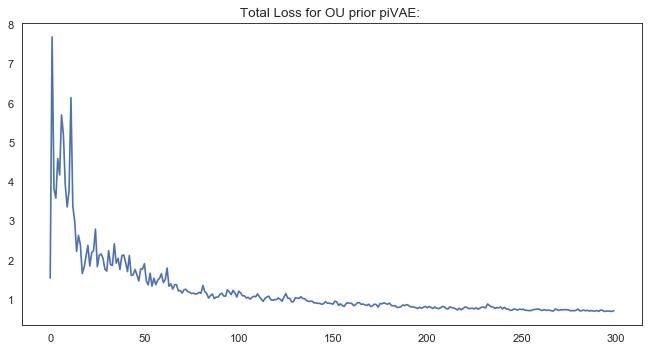

In [27]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for OU prior piVAE: " )
plt.show()

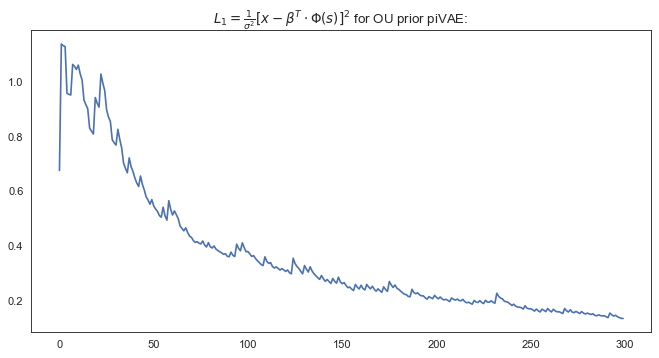

In [28]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma^2}[x-\beta^T\cdot\Phi(s)]^2}$' " for OU prior piVAE: " )
plt.show()

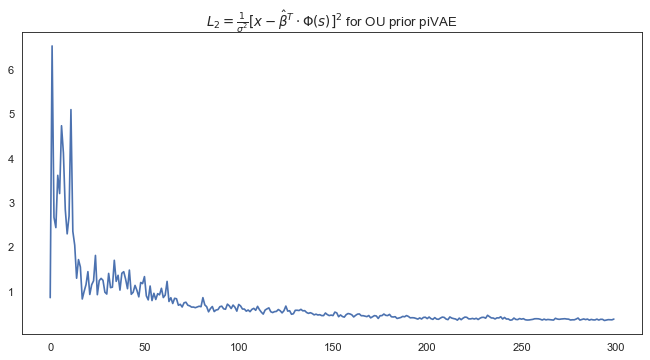

In [29]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma^2}[x-\hat\beta^T\cdot\Phi(s)]^2}$' " for OU prior piVAE")
plt.show()

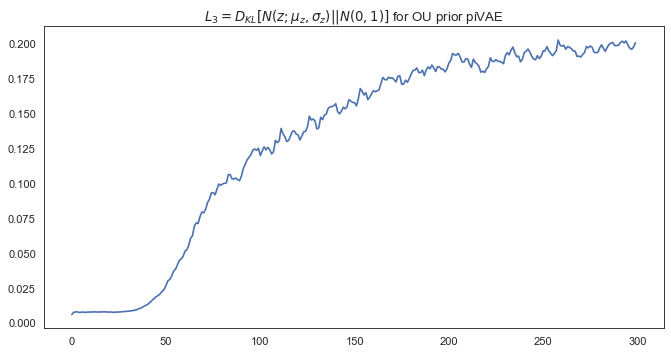

In [30]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$' " for OU prior piVAE")
plt.show()

### Generate OU samples from piVAE using $z \sim N(0,1):$

In [31]:
num_piVAE_samples=5

In [79]:
test_pts_for_plot_tensor = torch.arange(-5., 5., 0.1).double() 
test_pts_for_plot_tensor.shape    

torch.Size([100])

In [80]:
test_pts_for_plot_np = np.arange(-5., 5., 0.05)
test_pts_for_plot_np.shape    

(200,)

In [81]:
piVAE_samples_tensor = pivae_model.generate_x_samples_from_pivae(
                                test_pts_for_plot_tensor.unsqueeze(1),5)

In [82]:
piVAE_samples_np = np.array(piVAE_samples_tensor.detach().numpy())

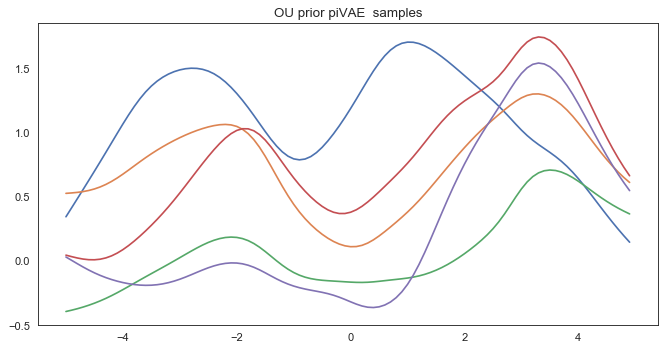

In [83]:
for i in range(piVAE_samples_np.shape[0]):
    plt.plot(test_pts_for_plot_tensor.detach().cpu().numpy(), piVAE_samples_np[i, :])
plt.title("OU prior piVAE  samples")
plt.show()

In [37]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_x_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [38]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [39]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        if(z_sample %1000==0):
            print("sample_id",z_sample)
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [40]:
ls=1.0
sigma_f=1.0

def ground_truth_OU_function(locations):

    cov = exponential_kernel(locations, locations, ls, sigma_f)
    mu = np.zeros(locations.shape)
        
    OU_sample = np.random.multivariate_normal(mu.ravel(), cov, 1) 
    return OU_sample.T

In summary what needs doing is the following: create a long series of test points of size say 1000. On these points compute x-values of an OU process. Store these 2 series into a dataframe. 
Select 100 points from this df: 100 s locations and their corresponding x values. 
Run MCMC on these 100 points and plot against the true value. 

Then select another 20 points from this same dataframe but which has not been used to run the first posterior. 
Run MCMC to get posterior om these new 20 points. 
Compare the value of the posterior st these new points with their true v alue from the dataframe. 

In [41]:
s_star_np=np.arange(-5.,5,0.1)
len(s_star_np)
#s_star_np.shape

100

In [42]:
x_star_np=ground_truth_OU_function(np.expand_dims(s_star_np,1))
x_star_np.shape

(100, 1)

In [43]:
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
#df

In [44]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i]
    x_obs[i]=df['x_star'][k*i]
s_obs.shape

10


(10,)

In [45]:
#s_obs[0]=df.s_star[0]
#s_obs[1]=df.s_star[800]
#x_obs[0]=df.x_star[0]
#x_obs[1]=df.x_star[800]

In [46]:
#add noise to ground truth
sigma_noise=0.1
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

Text(0.5, 1.0, 'Ground truth OU prior and 100 training points')

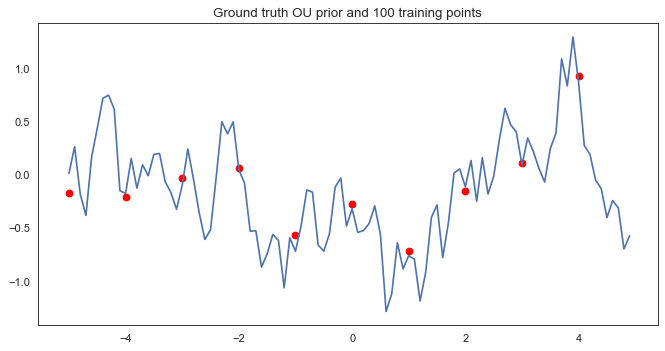

In [47]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')

plt.title('Ground truth OU prior and 100 training points')
#plt.show()

In [48]:
z = torch.ones((z_dim,)).double()

In [72]:
#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=30000
MH_proposal_sigma=0.5
obs_sigma=1.

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
sample_id 10000
sample_id 11000
sample_id 12000
sample_id 13000
sample_id 14000
sample_id 15000
sample_id 16000
sample_id 17000
sample_id 18000
sample_id 19000
sample_id 20000
sample_id 21000
sample_id 22000
sample_id 23000
sample_id 24000
sample_id 25000
sample_id 26000
sample_id 27000
sample_id 28000
sample_id 29000
mean acceptance prob tensor(0.4876, dtype=torch.float64)


In [73]:
mcmc_selected_samples_run1 = mcmc_samples[1000::100,:]

In [74]:
mcmc_selected_samples_run1.shape

torch.Size([290, 25])

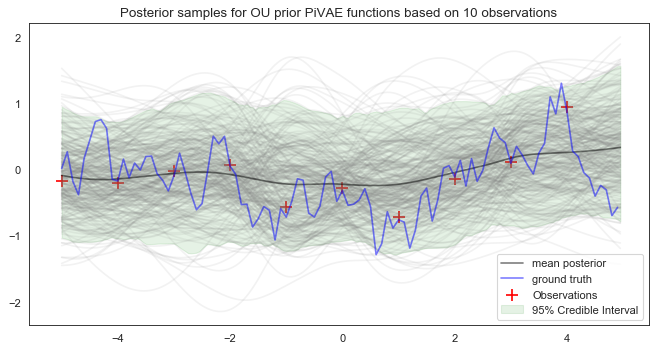

In [75]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.5, color='k', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="red", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(loc="lower right")
plt.title("Posterior samples for OU prior PiVAE functions based on 10 observations")
plt.show()

In [ ]:
#from the same function that generated 20 observation points, get new points 
#see the value of both Pi-VAE and GP posterior. 
#Compute them against known function and report the RMSE. 

In [ ]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_20=np.zeros(nbr_new_star)
x_obs_20=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_20[i]=df['s_star'][15*i]
    x_obs_20[i]=df['x_star'][15*i]
x_obs_20.shape

In [ ]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_20, x_obs_20,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth OU prior')
#plt.show()

In [ ]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=80000
mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_20).unsqueeze(1), torch.tensor(x_obs_20))

In [ ]:
mcmc_selected_samples_run2 = mcmc_samples2[5000::1000,:]

In [ ]:
mcmc_selected_samples_run2.shape

In [ ]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [ ]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_20).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

In [ ]:
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_20)**2/nbr_new_star))
RMSE

In [70]:
def check_beta(model, id):
    
    test_points = torch.arange(-5, 5, 0.1).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_loc_training[id].reshape(K), dataset_OU_training[id].reshape(K))
    plt.title("Reconstruction of training data")
    plt.show()

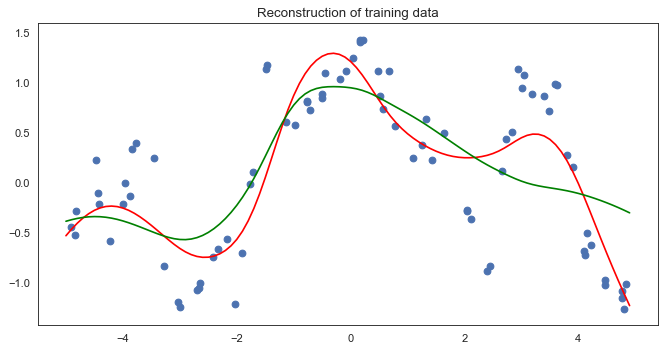

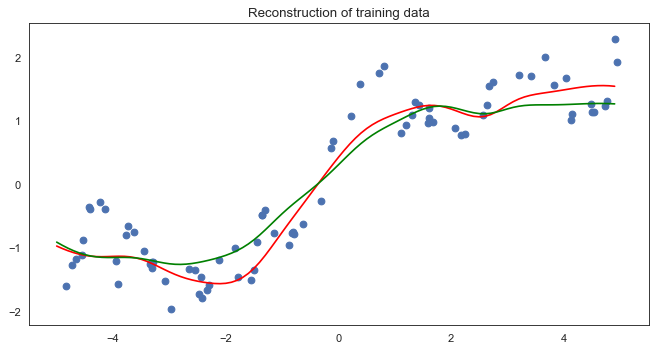

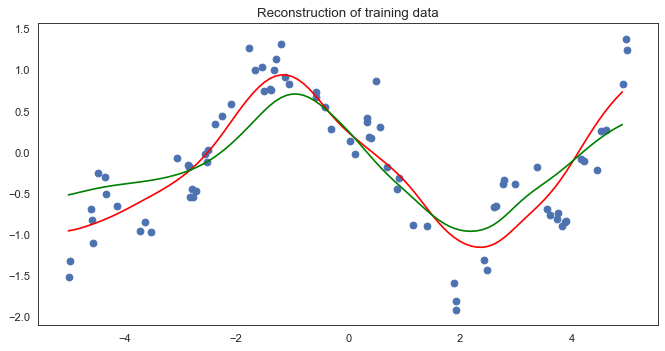

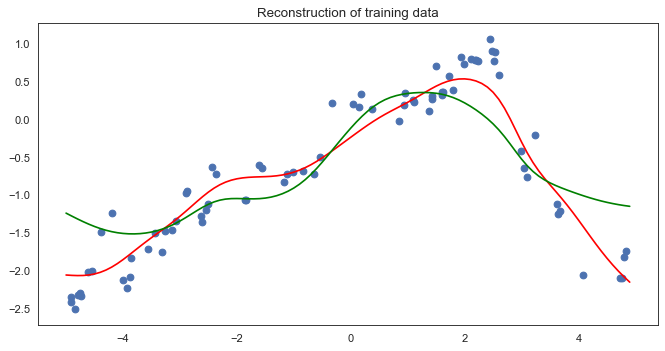

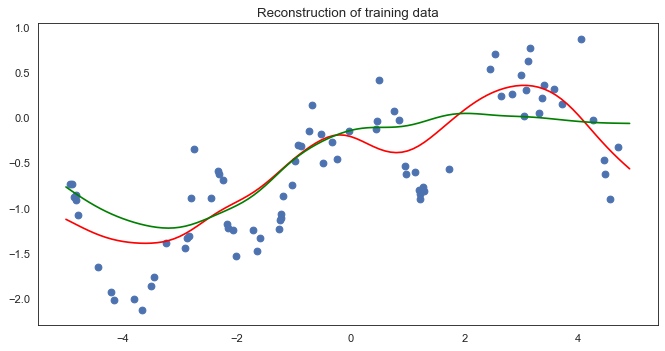

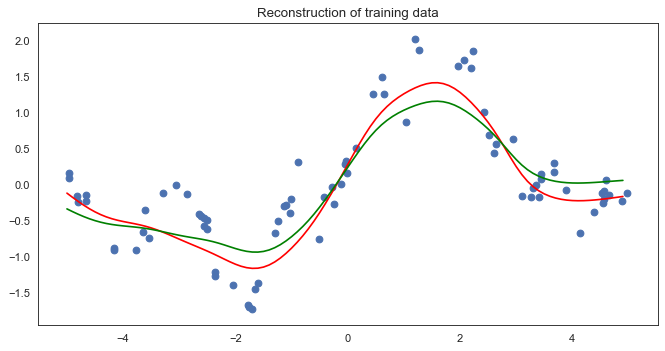

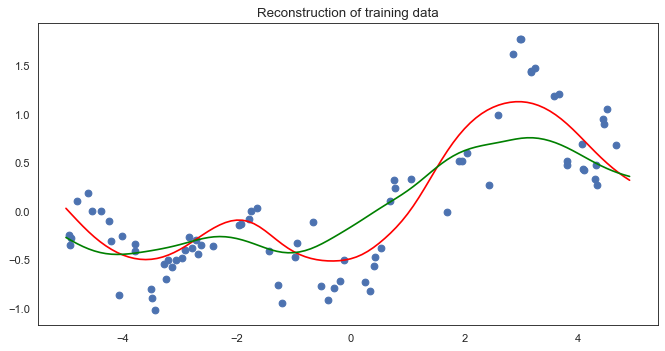

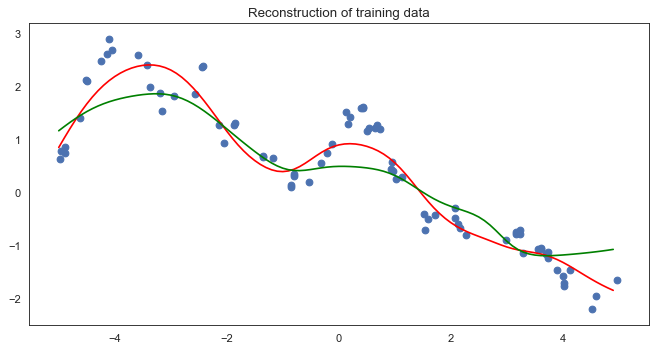

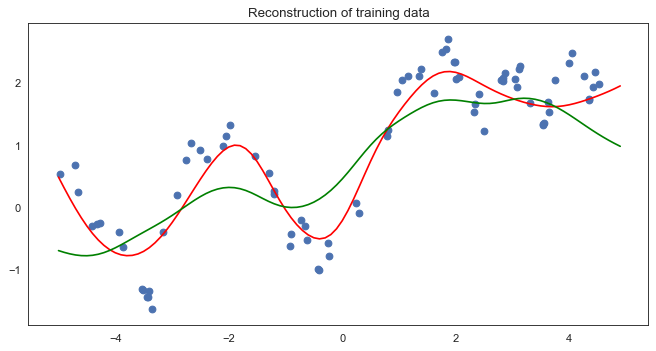

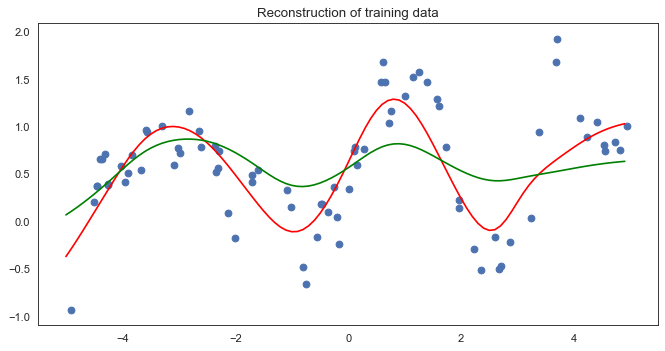

In [71]:
# ------ Check reconstructions of training data -------
for i in range(10):
    check_beta(pivae_model, i)

#%%